In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import power_divergence


mag_v_sun = -26.72              #Sun's V magnitude of Gaia   Jordi et al. 2010

## Definition functions

### Model Magnitud

In [2]:
def model_magnitud(theta, data):
    """
	    input:
	    theta: dataframe with parameters to estimate
	    data: dataframe with the real sample
	
	    output: dataframe with model
	"""
    mag_v_sun = -26.72

    phase_angle = data['solar_phase_angle']
    range_sat = data['range_sat']
    cross_section = theta['cross_section']
    albedo = theta['albedo'] 
    mix_coef = theta['mix_coef']

   # Change degrees to radian
    degtorad = lambda x : x*np.pi/180.

   # Definition coefficients of equation
    coe_1 = 2/(3*np.pi)
    coe_2 = 1/(4*np.pi)

    phase_angle_rad = degtorad(phase_angle)	

   
    part1 = (coe_1 *((np.pi - phase_angle_rad)*np.cos(phase_angle_rad) - np.sin(phase_angle_rad))) - coe_2
   
    model_value = mag_v_sun - 2.5 * np.log10(cross_section * albedo * (mix_coef * part1) + coe_2) + 5*np.log10(range_sat)
    
    frame = {'model_value': model_value}
    model_value_est = pd.DataFrame(frame)


    return model_value_est

### Sum Square

In [3]:
def sum_squares(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_observation'] + data['e_mag']) + model_value
    residual = (rest ** 2).sum(axis=0)/(data.shape[0] - theta.shape[1])
    estimator = [residual, rest]
    
    return estimator

### Chi square

In [ ]:
def chi_square(theta, data):

    model_value = model_magnitud(theta, data).model_value
    rest = (data['mag_observation'] + data['e_mag']) + model_value
    print(rest[50])
    fract = ((rest ** 2) / data['mag_observation'].shape[0])
    estimator = np.sqrt(fract.sum(axis=0))
    chi_estimator = [estimator, rest]
    print(fract, chi_estimator[0])
    return chi_estimator


### Markov Chains

In [4]:
def markov_chains(init_point, std_point, size_chain):
    
    chain = np.random.normal(init_point, std_point, size_chain).round(3)
    
    return chain

### Beta distribution

In [ ]:
def beta(x):
    sample_beta = stats.beta(1,1)
    r = sample_beta.rvs(x)
    return r

### Read Data

#### PC

In [ ]:
path = '/home/kero/Documents/PhD/Re-analyse/result_analyse.csv'
# path = '/home/kero/Documents/PhD/monte_carlo/result_analyse.csv'

data_sat = pd.read_csv(path)

data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['obs_phase_angle']
data_in['range_sat'] = data_sat['range_sat']
data_in['mag_observation'] = data_sat['mag_observation']
data_in['e_mag'] = data_sat['mag_observation_e']
data_in.shape

#### Laptop

In [5]:
path = '/home/kero/Documents/PhD/re-analyse/ready/all_result.csv'

data_sat = pd.read_csv(path)
data_in = pd.DataFrame()
data_in['solar_phase_angle'] = data_sat['solar_phase_angle']
data_in['range_sat'] = data_sat['range_sat']
data_in['mag_observation'] = data_sat['mag_observation']
data_in['e_mag'] = data_sat['e_mag_observation']

In [6]:
data_in['range_sat']


0      1212.143694
1       978.252647
2       998.606932
3       790.257796
4       926.757552
          ...     
113    1476.874530
114    1710.801485
115    1420.074586
116    1337.784401
117    1807.997292
Name: range_sat, Length: 118, dtype: float64

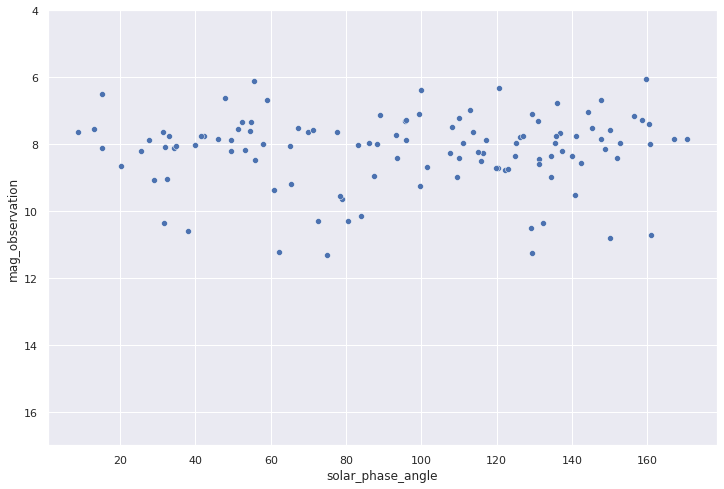

In [9]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(x="solar_phase_angle", y="mag_observation", data=data_in)
ax.set_ylim(17, 4)
plt.show()

### Markov chain Monte Carlo

In [10]:
p_value = 2.5
num_simulations = 2000

good_p_value = []
mixing_coeffient_est = []
albedo_est = []
cross_section_est = []

mix_init_point = 0.75
mix_std_point = 0.12
cross_init_point = 0.8
cross_std_point = 0.35
albedo_init_point = 0.55
albedo_std_point = 0.2

size_chain_in = 1000

for i in range(num_simulations):
    mix_coef_markov = markov_chains(mix_init_point, mix_std_point, size_chain_in)
    albedo_markov = markov_chains(albedo_init_point, albedo_std_point, size_chain_in)
    cross_section_markov = markov_chains(cross_init_point, cross_std_point, size_chain_in)

    mix_coef = np.random.choice(mix_coef_markov)
    albedo = np.random.choice(albedo_markov)
    cross_section = np.random.choice(cross_section_markov)

    parameters = pd.DataFrame(data={'mix_coef': mix_coef,
                            'albedo': albedo,
                            'cross_section' : cross_section},
                            index=range(data_in.shape[0]))

    model_value = model_magnitud(parameters, data_in)

    estimador = sum_squares(parameters, data_in)
    # good_p_value.append(p_value)
    
    print(estimador[0])
    # print(estimador)
    if (estimador[0] < p_value): # and (albedo > 0.) and (cross_section > 0.5):
        p_value = estimador[0]
        good_p_value.append(p_value)
        mixing_coeffient_est.append(mix_coef)
        albedo_est.append(albedo)
        cross_section_est.append(cross_section)

        mix_init_point = mix_coef
        albedo_init_point = albedo
        cross_init_point = cross_section

        print(estimador[0])
        print('mixing_coeffient= ', mix_coef)
        print('albedo= ', albedo)
        print('cross_section= ', cross_section)
        # print('model_value= ', model_value[1])
        # print('mag_obs= ', data_in.mag_observation[1])
        print('============================================')


result_fit = pd.DataFrame(index=range(len(mixing_coeffient_est)), data={
                                                    'p_value': good_p_value,
                                                    'mixing_coeffient_est': mixing_coeffient_est,
                                                    'albedo_est': albedo_est,
                                                    'cross_section_est' : cross_section_est})



/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.675859885878254
3.563879406192566
3.282037282600224
2.398942748745452
2.398942748745452
mixing_coeffient=  0.787
albedo=  0.716
cross_section=  0.96
3.016847677046825
2.518870242580492
4.0185326049357855
2.7165194162837314
2.7362130570971743
2.6036961970156054
2.6436075187078467
2.612545758807672
3.305912143438033
2.622144676322145
2.889529509340688
2.636851728021283
2.493352721400208
2.672550670157858
2.651601936478439
3.962459298396861
2.60418065637348
2.628023606575942
4.435902536075433
2.814921157720421
4.482277690543053
2.7783124487792064
2.645290515920486
3.8638235094498086
2.79919249931694
2.6100479773225413
2.828471313292085
2.5895370841658716
2.6091205518293257
2.603089335277515
2.746017577896484
3.4869423301678353
3.22128574908634
2.8624919454679727
2.6286324701953987
3.1710524978319925
5.814573237372707
2.6631530679034143
3.1534885038751184
3.7702713836123856


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.386180424690948
3.443148433889043
6.75133044563557
2.6335546554710794
3.21930713941791
2.5055809327356706
2.7273655988259002
3.1774046886819303
4.9734675474310865
2.9690488797160155
3.294025463551439
2.928669458315976
2.7090620732598674
2.507854134938721
2.6670243214166724
2.808673759356986
2.754219090008588
2.6856870277134646
2.4939179022550393
2.6824590492025946
2.9295426738286787
2.620760691069052
2.4772038239408585
3.443254591850911
2.688044928773319
4.169027186363955
2.580088785443178
2.4706206460956444
2.451083227515771
2.4590558895719834
2.4715274141681096
2.4275135000035055
2.74556631578384
2.3999767991645915
3.3623989913104455
3.4031044589641466


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.090633812832343
2.3873798389088194
2.3873798389088194
mixing_coeffient=  1.034
albedo=  1.106
cross_section=  0.467
3.4112497310896037
2.590317360011394
2.761223116870336
4.590002088073355
2.7002860590865447
3.657451161960356
3.288807484737566
3.5332669618075805
3.1785288267711715
4.212706690783642
2.8361835254464163
2.616689110984792
2.5738092401514208
2.6991727974988624
3.956527298166895
7.4145118326576975
3.206451183008803
2.797667863649101
2.9186757245268664
2.7301441522487466
5.88428715330309
2.591928554065151
3.680218765036104
2.583024471078568
2.982073261718108
3.2872629348578712
3.332778204379922
3.1877786572023203
3.4112447229239606
3.5895430369879446
2.504264897889847
2.859936190584819
2.4425615910790412
3.2518883928532616
2.9357372125391246
3.2863097556847918
3.275843214699301
3.5435537914902833
2.6314688907592143
2.7804948497798976


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.6769928096662126
2.6825030450996925
3.3234529971538227
3.8832690162154195
3.1621181353239964
3.7254562311815342
2.511622066014305
3.650945682568602
2.8327544166064293
2.752532476712192
2.9461054478050572
2.4643670553954355
2.511324278937006
3.46720486121765
3.4798255462442085
2.474731554667744
5.475382490686139
2.926247043735807
3.3960990227830212
3.172930530291847
3.0797472474311114
2.4654666893148107
2.5202409450422514
3.183063157677821
2.849593295236527
2.652861880983201
2.6150433945766345
3.175752123312988
2.4811795292020693
2.792093070194247
3.0151478313696156
2.650016256880062
2.5800006404441844
2.5880933825115084
3.164034232978284
3.175132163132554
2.7557365085684364
3.1276924771536843
2.708124400669079
3.3419872135801127
2.694975932101382
2.9963664184890857


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.9509156224918645
2.635772817462827
2.7995435502540853
3.4941817295339646
2.7405467179663816
2.6526176516941855
2.740780181390401
3.2028627274780006
3.1905450289385633
2.596212309926813
2.6924729180255644
4.170130504538715
3.1867770417416583
2.896308992165769
2.4243222717998307
3.60318415151699
3.728958219956864
3.2436145181283607
4.226654935307224
2.603506833254572
3.3736379855492804
2.412815547056017
3.4297609754325054
2.9034846152184857
2.7980047242767014
2.9757386245325175
2.7350981542906148
3.113109024996211
2.554112937817139
2.6918131204193463
3.9370628192327524
3.2213207816579597
3.6813178889067326
2.783861604184604
2.9372999734208425
2.553305264495363
3.5690475689225862
2.618751631893643
3.163499266386849
2.6394244553314636


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.161684539718866
2.859806001230377
2.45666226308108
3.9494464973211447
3.8708369852617515
2.66729714859805
2.8393538102077023
2.7628597648841877
2.645667896406129
3.3736875191587354
2.800646062393787
2.53295986840703
2.8806419674038164
3.370134688199016
2.8039753476213267
2.631631616293623
2.42875953926154
2.968390764613917
2.7547255488314653
3.1597901592000395
3.168514742598705
2.8492037284584204
2.524844428303687
3.2178902739089414
2.8786100421699
2.4075251663305735
3.463534366630545
2.4449794629557235
3.641907391586057
2.7635876295866995
2.639628068180066
3.8296090001521894
2.8630297637297346
2.643781049418479
3.1273515946278114
3.85262386455664
2.6642042387001754
2.615156625778389
2.6380811645973123
2.720217099408307
2.5687398826329453


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

4.327666611791133
3.1952644195549116
3.614456303967806
3.3716392085241855
2.8774849294042886
3.8874487565189053
4.163814500783347
2.8250999516390336
3.179202781624643
2.4252239694745645
2.664029310295464
3.062698811250035
3.16721923566966
2.5846818741939805
2.461656928446199
3.4417060834153745
3.3705040464007467
3.040218430487515
3.6508250578996018
2.741050810762603
2.893929349757563
3.849787719784171
3.542766566647071
2.4350777477157735
7.646978180999989
3.672929035032305
2.4221098471075466
2.4478031281124104
3.9504998637854327
3.3905805529871174
3.624749766836353
2.980405616476301
2.6744845274033433
3.276110326037882
2.5995680094598494
4.326258942796853
3.110710777903324
2.720910182699149
3.1734260423748117
2.6281803268383146
3.2307192342205666
3.149489661885526
2.7817374896609577


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.5334899946814433
3.5065065244624534
2.7218893140376963
2.4449072529019666
2.5771495300051215
2.7573182616482668
2.953404853028806
3.3659294589452795
2.5766978156537887
3.161853793655786
2.4845971392343644
2.9357001092358197
2.793466393501869
2.553065954292177
2.648818047778608
2.767759895878622
3.1892273888763953
3.573423991460101
4.617189217692091
7.621025702671368
2.809257241706842
3.580078483811584
2.6487467148546995
2.612611696826383
2.4850786384347066
2.7653035821667196
2.6868118302171604
2.595978926283545
2.6199054741819063
3.6841845729752274
2.5484809772395387
2.587856422273643
3.912923329960075
3.293528571335135
2.816322243912932
3.459562637225684
3.249558899238172
2.480909645753249
3.655518310912864
2.518616807102596
2.815599080309301
2.664423536630813


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.846699326357753
2.7038904441573473
2.702577865838713
2.983050146069887
3.4379196598596304
2.8701321571754352
2.79733734529184
2.7502724708580573
3.9260152808367312
2.7111978134729218
2.9145803348123835
3.9006925140300854
2.558424672643065
2.8051244503017325
2.7218273367438637
3.9330196872785783
2.793634466846342
3.1704759783776115
3.5349613866448206
2.9035105803996437
3.4077241578046604
2.6839069828774016
3.3759069536000132
2.7660814640674003
2.4875302347948174
2.7677824126644377
2.6610567606664755
2.8689754983963245
2.836873185149065
3.170231070744281
2.5903464596744143
2.7393291882143176
2.862639316574209
2.6844344751405416
3.3595598619316975
2.92945130671522
2.6736187469653134
3.3079774505668422
2.792975534609734


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.4416165720058127
3.293480869277019
3.2233848933442304
3.9651990714004284
2.6816066593336365
2.7587283680773496
2.8696008333235894
3.2754780819097276
2.4456106049009345
4.1836786282744525
3.4347409194979575
2.8615318440536885
3.223403380091067
2.598115609374275
2.8509247119574432
2.7622477489816553
3.2708537369024135
2.7831404640207626
2.668719779681119
2.4108169729865723
2.4525378373919193
3.1609526505472307
2.5470307812089636
2.90837569951712
2.8230637114753026
3.6107907115032223
2.538005602807983
2.8117146527008297
2.7176361180734587
3.333098865217191
3.231285742306892
3.164685356481808
3.285756249817279
2.443350672276623
2.4307656049360773
2.9110670909968452
2.654456465575955


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.221214490695859
3.208558129243141
3.2885385035640673
2.5587460230338785
2.6992375524506795
3.1598362786008933
3.462506396876898
2.7377539873438446
2.545437565681321
2.723089906905172
2.7099617761162675
2.431169866546557
3.446045654580981
2.7833075359113635
2.4616751517877535
2.4299032237732785
2.8187115303716324
2.7353612396997873
3.166461984754904
3.6515088285940203
2.452779148339325
3.180682450618346
3.15976523519969
2.926666068797054
3.0741719941486294
2.4892385945173783
2.8674785950854043
2.568077894542059
3.1784798285541918
2.8704424034468627
2.9480581337814984
3.401942658118125
3.1997590130904388
2.5852011733285534
2.7852366819495598
2.440579847024088
4.243037177214926
3.6643634604104736
2.9241935781041315


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.1719518977655534
2.615764552625396
2.7190911195763143
2.4066760132835063
2.525839506278641
3.6524901303355053
3.2147363295074456
2.559067621116369
3.969396748454755
2.433613900376424
4.704933018943132
3.075690061425824
3.8019983279792986
2.9491784104813474
3.7580865427042762
2.749815130265131
2.448446602181344
3.2660435861187405
2.78339049672791
2.5580849379655137
3.266494756490208
3.177279774018924
3.159798174407659
3.4104651890676827
2.859035351582735
2.8092141084351643
3.740120190054633
3.1598352091356143
3.2091534576604697
2.946814507368003
2.8870844892771297
2.5725862912071955
2.717704499006147
2.474317317628015
2.488287690083243
3.8599268330607104
2.4591095899652275
3.0044502855099604
3.9365274078756483
2.905805679689065


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.2032953190778763
2.389744106939219
3.6279520002868457
2.6610176750258288
2.7340528979934557
2.8425529838914065
2.550478173678252
2.745349376899809
3.1753736500569314
3.159902021115272
2.766329189845278
2.635334835257229
2.9829370487037066
2.575974587286721
2.675282743842104
3.764442922070769
2.495572038712476
2.716647755255949
2.744895750874595
7.143370009866628
4.127421643358096
3.185825691664652
2.722084854378792
4.611290624316043
2.4295922359147712
3.6917747878998144
2.5809864771210487
3.7487718186417207
3.5428976884474377
3.2554216920756875
4.101092997344518
3.0205208018753495
3.249240674607446
2.853768454924413
3.0936135595715366
2.6388904612155044
2.8335500381741805
2.7335058832059937
2.6281800136437874


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.728819074402385
3.2378782464013844
6.434712968808077
2.4746990762576146
2.990149243859376
3.1888571112239306
2.6997693891620966
2.8493728662040603
2.7904395170627025
2.4681580095262547
2.601432532275507
3.360352878063128
2.726157805142662
4.494317295080181
3.6244275636502596
2.7169529111138497
3.183798870646718
3.126215772220937
2.7437577520318577
2.6039108933029667
3.317445951753571
2.4825013371281517
5.2691772342012655
2.714273605090625
2.6584589386666195
2.8330556832457074
3.1879952904422626
2.741283904445502
2.585688400947333
2.617052370727462
2.387664538734617
2.8452638712733807
2.495197203029946
2.816023680010657
3.2609599675741308
4.471430224404752
5.416553226202146


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

5.290283892748092
2.6446108495103164
2.6985297867555755
2.4750780977658264
3.1711198118744743
3.1974458006210633
5.315285682762684
2.6526140219968664
2.4903992845230762
2.622210145560384
3.3233480653383625
2.8091665621335244
3.28128067986625
2.6652546120137477
3.9183867784983564
4.774300001772462
5.803006706607892
3.377835824343931
2.748356444036442
2.6611407143549113
3.1834272207005663
2.5680749300910155
3.160458582910065
2.457506948552787
3.236244654650839
2.767392238724129
3.1605936990631625
2.8378805930557953
5.15989275791342
3.2252555910054155
3.245327854361031
3.2036359418722276
3.4209372895014574
2.817629162004188
4.433648530483438
5.093290524168232
2.7177458441047277
3.2903821414374725
5.663019707547165


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.5853943867249685
2.809489874338326
2.5973638087722697
4.461372819628361
3.535723795006542
3.7851395922864466
2.7869577793477083
3.6483216202930064
3.260383870217244
2.4309495152377383
2.835843487483952
2.671715197128348
2.7357736021929546
2.8373155108906785
2.46055707860881
2.759119004711084
3.199576334911541
3.761714902527518
3.2823194838572407
3.4688927763833215
3.2913363149295165
2.787761170876198
2.791125627775685
2.6849373651754846
3.1615329475582885
2.937110070515817
2.841538810928838
2.8441351293446235
2.676502410683327
2.8016773046598207
2.8997304652355407
2.9350606681490095
2.4708110753011576
2.6947812782157023
3.755853747399389
4.414154812671519
2.667006389362688
2.7762511629243862
3.4594770026975663
3.2758842097126872
2.57964828836386
3.3540969792368363
2.778117133428808


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.5139187579917994
3.179567455995616
2.8571362720221543
2.6499923473386358
2.78567960134746
2.866809255980128
2.6073322413881037
2.7433321667575012
3.2682046607771595
3.8588659273534525
2.683138866975684
2.425997355644146
4.4625381339568895
2.829770373387948
3.0012056064430324
3.16775686015682
2.523799552430669
2.5274042067755262
3.301166363950852
2.580995930546028
2.873534115138928
3.207555764631129
9.47837575219996
4.724995762643396
4.265778397045059
3.719715985989427
2.7376502301084176
2.6820541422244455
3.745552203443212
2.6766058810513558
3.5476399925478392
2.7857453748153356
3.388994091875067
3.5839100281878102
2.554725282517675
2.438696201845649
4.219244909216156
3.2439197303883405
2.500084505632885
3.5966069722441825
3.2353258470923976
2.912630341829304
4.6945216619802945
2.857494774956266


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.8574586830222812
3.7560962428998406
2.605004426136766
2.6624404977433027
3.371927346137447
2.914580791199434
2.4179388351377225
2.3996062518008228
3.4732989661215385
2.513519280151027
2.410941593667401
2.5424681568084506
2.5505114955412553
3.2752704094326295
2.649500238830206
2.4103089072336448
2.7693126363214318
3.2401055689968548
2.679461683454612
2.542975942993206
4.731839259614856
3.208513416363719
2.9468974870862232
3.1944679063231303
2.679358104616944
3.5832451946033967
2.7057159320602935
7.537843918655709
2.797840333443342
2.6368782144108884
4.188814349378326
3.3017830449102856
8.258362362659245
3.1597642235796135
2.5831246136023163
3.181973985098117
2.780352203839305
3.9122904766214868
3.935004987655082
2.6702558589001555
3.541237099315933
3.0257789801555655


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.8331595365574707
2.3905378963741466
3.809969111552372
3.173747743174972
2.710714846479287
3.270241493521419
2.5791261404591017
2.8571362016709383
3.160324199455025
2.5761728395813788
4.208571670900142
2.7182243655977163
3.7230482223677726
3.3434766994709566
3.168760955372544
2.7433435730510394
2.490838476585724
3.1736505685889895
2.6551123028684613
2.581547421607711
3.1880378580651607
3.3964104546466785
2.7653846567878353
3.9229699536937304
3.2655311425620583
2.8494268671221072
2.52373235480512
2.5001519150774403
2.5737928235177576
2.5772689749356488
2.756793833286779
3.0687904399565538
2.430213647046279
3.1685270498562033
2.96275838058489
3.1706822020819745
2.8229452098423597
2.6897022393464742


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.0741837400714958
2.5080607388660052
2.4529871144641895
4.071125537018248
2.7667483202079897
2.8124001021284735
2.683365609944414
2.6589455295381574
2.648104029327394
3.938291404671051
3.489259329282497
2.7746601412806116
2.757346148828017
3.3689742931147872
4.783926274214232
2.66336001353796
2.578628031955681
4.512834042901398
2.963031611821732
2.4907535025941843
3.1725264252572267
2.4117445606588377
3.8383691802754805
2.6294994411639117
3.241843684821614
3.7366767890561934


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.6753423921044566
2.390174495057236
2.6609289825410736
3.01007848278615
2.609533407890021
2.8162553978511844
3.216204270548479
2.834507695821335
2.798756294449335
2.523777705432573
2.9502706337863516
3.907810014516985
3.617897879684638
2.6690675225056992
3.4698063992574357
2.798345983100701
2.742170006315361
2.5348701322371
2.6690598549893627
2.9395601014640715
2.538858317016512
2.6868244846939042
3.1611000253122574
4.949280841240446
2.5812195408400136
3.2709562961007506
4.716061586586558
2.785698732223171
3.6601722223121604
3.0887703554881445
2.986200342204752


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.5988062306513546
2.7813282141459323
3.6163637899710155
2.811278601046821
2.532248939203268
2.858781313842846
2.9890904604815374
2.7820701137734996
2.5313712489979396
2.6742803072928214
2.4694684636897613
2.4528756805208376
3.6508038738299233
3.6574149131943123
3.9615853066184337
4.047712278868301
2.7570611691756377
2.402473019712505
3.1648956908562083
2.6717534174821673
3.935840540867635
2.622577923549055
2.7193659513141375
2.948890915591774
2.800556132412944
2.6785163945627546
2.668589030068177
2.5903025509532203
3.507299527997824
2.712329022107264
3.3898723609459487
4.739205906288101
3.190674318796459
3.6416260069913178
3.9015523093896136
2.7338390190636086
2.642466151956101
2.7634496454124386
3.1607665175699418
3.7787035460208016
2.425062105910205
3.7071323382435506
3.159786140596038


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.7497470394160617
3.361685100305713
3.2643591066005997
2.74575118515871
2.3908660548215552
3.0961178589084084
3.274874515110433
3.3518095811258313
2.464462245895073
3.135501786090074
2.646827093617705
2.7592349241320635
2.433128752985762
2.723164073484583
3.0050491103972754
3.1689061068930013
3.244773443140087
4.454366534068291
3.9357678100051348
2.4155901800271766
2.7357027052392775
2.578688128699304
2.7789777569143808
3.424769001359326
3.4193069949010026
2.724591571987478
7.331813260423613
2.762259586809443
2.559265421865893
2.6511715022248294
3.3863595997119864
2.7878730622454535
3.6257581591373906
2.7802640308506477
2.7295595293811092
2.977192351336102
2.7428782077175127
3.2076112034767523
3.186219599637165
2.588935822163033
2.4374590685544986
2.709037251755998


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.8239576145877963
2.7119842022401386
2.858870074513532
2.442102240182665
2.652983797506402
4.187847376328402
3.702788383329949
2.6927736359062147
2.5843055202877876
3.220687044658646
2.7093718266300932
2.5809920431260918
2.509262717509456
2.851849834536597
2.881492324682178
2.7145987151672255
2.6853592220623903
2.858634615211135
3.7021677737759573
2.8836061409521823
2.54524002989144
2.593466361974154
2.7632299984488995
3.202365296565958
3.634628954243217
2.566509782024229


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.2969006929794062
2.4009036385633467
2.885115802305964
2.9936849548751696
3.9716571513395085
2.7084600747723218
6.834600493970899
3.16158521868597
2.389774464997717
3.8108893537423314
2.6890893945264853
3.576595383583432
3.1882245350400993
2.9027761698263235
3.609795040417337
2.598705133455763
3.614053276657084
2.9606323495985336
3.0565000454948015
3.160791888439461
2.4730007238814338
2.5749921980215094
2.718311230289042
3.695290607865352
3.3457916399940313
2.5309585597867628
2.719561816723437
2.669286016069288
4.2528107785489215
2.8450791776203217
3.024405592505999
3.248767513255363
2.521999828371415
2.628890795511033
4.014201133986994
3.1835853537585304
3.1141597765973503
2.5808341878347445
2.68647185743328
2.6162729804414577


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.173930045864535
3.1693640380308197
3.554794118261829
2.591069150448433
2.6772994706666338
2.4370266476747613
3.3964915742023565
2.4465056742878266
3.863517113943243
2.6945671504134543
3.4780786823455494
2.59789822014478
3.1603767315678843
2.738818177546697
4.092418288562677
2.7413171874900035
2.6251354363504174
2.5371246008836943
3.198253552779997
2.6118386896239505
3.610685722750321
2.3915251622337217
2.729340385012109
2.8362954767431643
2.773296410787659
2.595462871492722
2.575170281383159
2.716091766861449
3.2458128556546635
3.2619606555972664
3.078664789803304
3.200826666963071
2.9627054467944887
3.1598154133485825
2.867099916063242
2.7784445300881084
2.3990810308154122
2.9274378618372587
3.180139629077914
2.4319551482491124
2.6182429211364373
2.638073344961603
2.9505613631875467
2.693781125892787


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.72768360581878
5.66448691759585
2.421364190370239
3.7802363985343748
3.046337787598249
3.47138321831406
3.440672129388234
3.332181766824701
2.7668715722731823
2.4552547771293955
2.8629014725970006
3.1654936864780727
3.615369394717226
2.57436119663929
3.5731581339391387
2.6961540862021223
2.4856576158267556
2.581239994793843
2.5718808482292608
2.675799049243239
2.552459740721939
3.234540596858148
4.762154083078064
2.8649386173429336
3.3180787391823503
5.215719673710004
7.5893231828900305
2.6162429289337874
2.79384539319291
3.5303008253787285
2.754677409586415
2.39459718876677
2.5197408731941593
2.628256334228866
2.3884432876743933
2.8432398080027794
2.835483288790327
2.9848064711349904
2.7517679952844816
2.714243006450752
2.7702437130249282
3.2104839387908477
2.5412349763008133
3.7979213405893932
2.6165810222014603
2.7366596187221797


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.4999522998818184
2.428593606901456
2.758961024026921
3.6648257550288244
2.6426779264213596
3.274167506122067
3.4140801521188564
2.397371960666581
2.436897823470042
4.1987438988732
3.07140537309203
2.480473454626165
2.791370477841042
2.4676417518531015
3.3682600990715033
2.581253116539923
2.8307138872722057
2.790372400136196
2.669795668270066
2.419647404601296
2.4081617686637475
3.172755244039344
3.0315609507790477
2.506489994900913
3.27862000377486
3.680079591170874
2.8128011152015437
5.9770265742676285
3.4475698598276074
2.585067596496591
3.522944870575034
2.5106655335270065
2.7824521858845617
3.1626869433201157
3.509882727408356
3.2875106024622784
2.7513200226230055
3.50050578590616
2.6795175210802933
3.572095987564827
2.645404259096445
3.4969500539423706
3.242718455466594


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.833876310395747
3.161630237517621
2.4493749986284157
2.8981911371477334
7.405596063168745
2.5886151096285275
3.1742725934023355
2.65511210924174
3.794689819516621
3.6863098416539772
2.4300024788917
3.6430888323871105
2.4977531556768584
2.4625110740413536
2.9071213567649674
2.8668759025666173
2.8791424636805485
3.4827447709480026
2.5942265915769265
2.483688870668724
3.2094940259403537
4.9344728742112345
2.908494955131628
2.4599888206555343
3.88639255030442
2.7937174175310466
2.579263370041998
3.685453691726026
2.532403836311215
3.560574066875201
3.530378671810349
3.3991183341861286
2.760414950181536
3.2190161105599038
3.7084788056725477
2.629736427829907
2.388868552797123
2.7938502387946285
2.589503576462464
2.8773734942589826
2.435128227724164
2.671371080941845
3.414971906811205
3.2878560479700365


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.799618580722602
3.8031971260231434
4.658733213448461
3.7838838855952126
2.727690290602372
3.05098637018993
3.3254111884582165
3.3619608105662313
2.4728538316423743
3.943196289089851
2.9316899750977456
2.828256265877866
2.557979118559319
3.1638144875022722
2.5062368326692144
3.9907646842706606
5.388235766794657
3.2711815383312097
2.4405894104586876
3.3312151880966785
3.3562640442086495
2.467281177212812
2.4990407981064036
3.6014201901404763
2.513184895725312
2.800243031344881
4.527157516151918
2.6396204802765255
2.5373776829236614
3.20639414236442
2.7763058546532915
2.554963716124349
2.544483970577741
3.8290600731442903
3.0350762445361124
3.1571198563582348
2.7974929743044354
2.541066452354538
2.673189094621482
3.2105247551362233
2.6956095361637895
3.0048823785627614
2.471691934577145


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.4066240129865193
2.8261969824374313
4.232232880546949
3.7128159799985454
2.715125637278299
2.728796883997023
2.715948130749751
2.454793905069235
2.8910103756390484
3.031894661950525
2.5450048987216336
2.409050660727123
2.8363280327370872
2.926781918880648
2.6464771587523384
3.467108879976848
3.5384376843435876
3.976496800642539
3.83855009344778
2.9197382686785294
2.578132280449859
3.811400741205065
3.5135890085961092
2.487902378027549
2.823450387558973
2.7476355020342442
2.561948114707797
2.985620805336413
3.6276220354185926
7.670935722100264
2.5985381987092695
3.625729850632163
2.748384951628334
2.8133719470791863
2.5948725948217355
3.4323155557951694
2.721898740575184
2.5388733597608546
2.9520376274939033
3.193888506435906
4.783691924081289
3.4242500542598022


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

4.785055458167693
3.6898900835300825
2.832692807535069
2.666296839733451
3.562083642782825
2.8914656442222464
2.647162776602022
2.8154896804829526
2.796999783929395
2.583617810242498
3.766562459173595
6.401069991436248
2.418639908691814
3.1666923439024894
2.639166738556945
2.807940986588479
2.7130322681173658
3.497584080374592
2.7807858482862233
2.9454320909623903
2.848047955680487
2.7919377308308513
2.42676345461933
3.6252179457976217
2.7180677932209467
3.483694683572079
2.6419279469951937
2.6679826808972433
2.589549520032974
2.8358107207723666
2.86800452574188
3.048749063626547
2.77614104349432
2.6014437501624808
3.211627878369122
3.412806007304217
2.772678040078681
3.207061963789751
3.363747144136763
3.635234674161396
2.4601900879114824


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.8445815866262945
3.852475201977182
2.63255231828778
2.638526403610049
2.5874321842853654
2.6120544497463976
3.7310056726749714
6.150819530886952
3.207503160258663
4.027370264486624
2.5020742709506076
3.4118357025099693
2.871305089351893
2.9494744701771096
2.5990291404119064
2.787200819256731
3.2285408327109186
2.609322613724257
3.2047854253803094
4.274147070700509
2.5185586213298423
3.4603893360322133
2.834465252137612
3.108373968797844
2.9625203473998654
2.437771706411067
2.8763691329593595
2.525975155505636
3.2118227896288767
3.212854886020973
2.5758546715280475
3.489319419318048
2.9066166402189677
2.4982580639314835
3.3492408091215955
2.964251712624227
3.75686028668103
3.7343259778331057
3.87752233712496
2.6953912192773912
3.81993713130222
2.414163371189597
3.415718984671181


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.552939429455538
2.8426302753776307
3.3127197904385537
2.609679615670223
2.4257613451184294
2.6625538049104085
3.5870628005923577
3.160580207890275
2.593674258125456
3.544163671160839
3.6410770452014285
2.828452387577718
2.64803297404853
3.8113179306693854
8.267411708095391
3.5939347539735
3.0128254521787925
2.4588406679124364
4.070090790232329
7.247825281635545
2.6608695350934584
3.4155800831471903
2.5875238798089892
2.91154674393578
3.4345665625107826
3.2177432881431556
2.7622390774906918
3.454734711886314
2.614232605225017
2.5135500138972944
3.3022349143837797
2.402318177843014
3.8785225322801447
2.9573233520087716
2.68180847986357
2.8246569697265045
3.164961907900979
3.1986643093754963
3.5711102863013298
2.78055926355104
3.1693547281971486
3.6494726188262314
2.6439834380812792
3.1664470072043094


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.422046922495868
2.8142905716357527
2.604149186082276
4.401883301088622
2.8156294937588924
2.8816737141656463
2.778871218564713
2.7892790488093615
2.7895694645392615
3.249546346542084
2.5746942325012045
3.3129760714087335
2.6626194375261005
3.291076783606258
2.4578866825930112
3.589651313839143
2.7491838797812456
3.56040903671135
2.463162506189568
2.400899937241181
2.5223026784423697
3.3199214800460104
2.4345157276728253
2.8342308153254616
2.6326843459222657
3.4580093444895503
7.466022724970062
2.6995785621072925
2.646099764928096
2.7756497288013207
2.9184821167313344
2.497751553575485
2.609886809207034
2.6139017898266075
3.1956923779038373
3.1754789665337464
2.434698163364296
3.2850926372260703
3.168802140086009
2.6226362386742763
3.2505204093285824
3.606650792947729
2.557097546777618
3.234959586095579
3.273097091744615


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.632558004740127
2.922739459300333
2.911680913931698
3.496807210419125
2.693077409254622
3.1960072993418187
2.6341541945052747
5.383537436554912
3.161319748169138
2.896226623262716
3.017849789076195
2.422289031027227
2.462804300605996
2.698441932333862
3.208908455387141
2.6823182372102634
3.2077445818292905
2.693607989967134
3.4837826462220742
3.1237410221581334
3.221803210733461
3.345681957535087
2.6112152587496387
3.363109509545319
2.771447942310008
3.327623630626834
2.7199458110102634
2.5978324978490277
2.627386540262798
2.759597575010904
2.912911320807312
2.7001050352260885
2.452444127983236
4.119163868964812
2.7648481541060344
2.775949591164589
5.631744992103833


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.4862247588093416
2.906279407255253
3.8708001166350843
3.1658999656359104
2.7846873457552315
2.4968913041805982
2.4498163678341123
2.757014883173405
2.9327803755916033
2.446183212403816
3.1844498160962527
3.1513718143070797
3.615767046228451
3.2990453718792456
2.4613008156071308
2.5376179629124342
2.628142938044428
2.8303331104028717
3.5801556372744034
3.6464474627620573
2.5293228157575576
4.23352579493236
2.7405465893229892
2.5381419283760565
7.8911293543419125
3.1619875978348957
2.7803457269978735
2.6414385795949094
3.3610217629768115
5.56632623463701
2.771975341631679
2.7730814389465417
2.569405400675739
2.6134602858699036
3.6167675161458366
2.786057024912099
2.4758123035550175
3.1693274614631184


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.4665813632321076
2.753319773064024
3.890561171742144
2.3925440034683465
3.704824145469192
4.16408539831766
2.7814880978072454
3.1651818633444497
2.873521849235116
2.6980226283920263
3.7117668501483965
2.996174373801392
2.911042003884152
3.456434170387705
3.7694231455630516
2.6734337456801156
2.8123305076072436
3.2203692656955374
3.716236016934483
3.5584709760425777
2.6731477946588136
2.754509104932629
2.4551287881221033
3.9280891078527906
3.551355918486414
3.247776969866643
2.8099224849810502
3.321548887117278
3.3801966585489747
2.802997457115906
2.7181332733563486
3.4094348066335836
3.558011283977
2.6258343076368096
3.4487301168472224
3.447069986023158
3.3689134766868207
2.7020654630276564
3.296289710825283
2.6806785240981643


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.8128911550275713
2.556308662180974
2.8141191778713774
3.497860101560757
2.8527972921580336
3.4567893013894624
2.546314932270146
3.4288604066518102
2.773057081203299
3.5087971861984726
3.2289441430334285
2.4103745544162947
2.67575754187088
2.6808147581809734
2.6710917069241304
2.437874218907705
3.4441598082172593
3.208138898019107
2.5531790098355254
3.360885617164758
3.6386749857806753
7.694645745081096
2.7112726294354434
3.021020907394736
2.713548235661059
4.7978385741158
2.719125311844021
2.9434764042763093
2.4153184707911164
2.803832204775223
3.369656655956899
2.655029322429663
2.5086095574915626
2.6866233930914554
2.6148137614177327
3.2108308836847903
2.593629196255013
2.4648029624054435
3.4559067601674087
5.508962144978033
2.779306972102059
3.8515566339910587
3.6384918742855135


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.53206324978591
2.586739110428943
3.5330154816210966
3.43175263357921
3.8575154794557833
2.544752389172283
2.9948069296714883
2.703352084186012
2.4824784288037183
2.5208190878162697
2.8747495748526513
3.5422107479191176
2.5162809827172676
5.065113004989842
2.406380519391743
2.836679543928754
2.737812780539452
2.8617642753264305
3.252582575133323
2.7669558754962207
3.3058269720586306
2.7896128061228835
3.2648806887664423
2.8576274972877527
3.2356048962178368
2.680523859362795
3.672661579158169
2.5836847766449766
2.6779551530190564
2.675499094112927
2.740937904165649
3.4256491614552136
3.916277748439519
2.814207817506
3.5092179004108037
2.544590267854576
3.237922160470896
2.7712348610403277


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.587819617093019
2.610417063174198
2.7793803635509535
2.7660383222921814
2.908784145806339
2.4022972668281395
5.421364536827459
2.78405562783897
3.6930817708113763
3.5396840006700443
2.9041013376273117
2.7133072839071053
3.283205242997962
3.3182557005676374
2.749393588554974
3.3569655025416374
3.5231409579757886
3.1757866079322183
2.7409303563831857
2.8464453305398463
2.6793615436248586
3.87792090529803
2.9701731830804
2.893593480906921
3.7320566946668055
3.235052723247427
2.765802803578907
4.445502744254904
2.5788373114085217
3.249726337057452
2.4064357521395956
2.5896098219156625
3.1833864973423296
5.020086683798735
3.2508318402660397
7.43064865709947
6.417821263311895


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.302251719153069
2.580568350687666
2.5156350586240226
4.0755294257529995
3.9018225603063006
2.5947503146771007
4.331910612498714
3.4189769459524517
2.618111177959763
2.8638129818300975
3.229551873987651
2.8696022853481544
2.6821836051791306
2.637956375525496
2.707851640313995
8.088980699931415
3.2450998956019363
2.9210629954291294
2.787757007082439
3.163167150104529
3.23911707506914
2.735775865951131
4.297858326081024
3.785749907439237
3.5362312842436343
2.610318178204452
2.760198362807766
2.7272130087067423
3.555278351380197
3.859888821353654
3.691107482073921
3.4914188722450397
2.7454567622900714
2.855609310769516
2.6225409696489983
2.4014827083073946
3.190830742961154
4.01649338792516
5.430110491037868
3.5050017411022827
2.5210421362863853
2.6485553384141802
2.4597443867360838


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.5270691718717195
3.494396582269711
4.966408953821951
2.7557758917804005
3.161881315614712
3.2467801903458655
3.844559245885648
3.9712126729469714
2.4668428861711686
2.6282184795151577
2.6166132990757847
4.88687080376417
2.584373836488756
3.376051800800594
2.4868603980236257
3.8315076437373916
2.464289042548265
2.5889898492466457
2.6475889915245165
3.2995307253691526
2.7011197446566686
2.4061344383585443
2.5428310807598047
2.43377372404208
3.714462808894356
3.25441739095463
3.024361660990198


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.206749784340328
2.4930511569112936
2.845964944381176
2.8949921538295236
3.8634834101040845
3.721070246708028
2.809590539763798
3.4039117696018963
2.835283099336077
2.74025101687268
2.782091846877145
2.5157453365801907
4.239691536921785
3.3793964143167563
2.425886607079975
3.49393933322296
3.3001010131776662
3.5429649062488067
2.8665073455127823
2.713957786727834
2.994793959174765
3.76093111392256
2.6625584247208067
2.593275242149386
2.699849182068141
4.496638096523178
3.4996370826722702
3.3035213032032527
3.8662314433227043
3.3318075827576545


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.3520904279501114
2.7688503315042357
2.853504721114694
2.443975311858094
3.16039409319032
3.2458821417577477
3.9331143500227204
2.676147595092993
2.8343873770465873
4.46178865039721
3.281145334324231
2.5281334932515156
2.6151710165025044
2.4077966276401868
3.308569601163829
2.4996675707021927
3.577416492027513
3.537720883766653
2.44187778039488
2.672700625309588
3.6646081145054255
5.520341942122978
2.919505555616138
2.4527246955959825
2.7067771215883636
2.6794270268170646
3.658468752892459
2.4357602644134846
3.494147681541901
3.243665929383456
4.139046204487865
5.088345786773738
2.6294449797625585
4.408312694231415
2.5316935380496823
2.5864308908871374
2.807449050817697
3.3178587060164504


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.8079789728965787
2.627950196693426
3.4625705160821374
3.1604608453458285
2.449872061793896
3.591187880579425
2.6284528977708463
3.6013264851033506
2.6599580975557604
3.158821091796753
2.5497379477528748
2.580896973167008
3.288542214220326
3.4138906203391843
2.786725791968119
3.1659402698818386
2.7676935475871605
2.8583578699449483
3.1815593133928375
2.747661822489137
2.9496217737397257
2.9829090929719704
2.6548051476091508
3.305997095258352
2.813476048772491
2.9250763245202984
2.391980330704238
2.6754990944663923
2.6323982476972625
3.0012656976007497
2.6894588390745144
2.9844422489479125
2.6240690806762053
2.7648791089116913
2.657052749869795
2.679552772847582
3.0543758928244085


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.834994735684269
2.670918552317421
2.7093533956129288
2.4441073949591106
2.4073397350504715
2.5205780914834386
2.862528228659904
2.680887297752135
3.159873080476779
2.6702810740272214
2.6999257606564933
3.6009426464130017
5.593838723377571
4.922647777165853
2.9205160469128324
2.611043796841158
2.78394534292116
3.218237930000108
2.5952148194561673
2.6357753011584535
2.4052352967492188
5.357151083625459
2.7711923249825463
3.483044376382309
2.7919572315413506
2.726500888992125
3.1646074058199085
3.298962455973348
2.987833031046703
5.7245074564366005
2.7186451102672367
2.5286217479920805
3.3729757693973816
2.6349944486972454
2.6735869813441964
3.2565212874766103
3.3471985083045124
2.6664356729219696
3.0446706424279055
3.2434278084383807
2.6175564363182664
3.9901460528015673


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.5234500966478066
2.424834905228811
2.446891468389395
2.6698711480735917
2.6192053169664278
3.188801769900104
3.993915877214565
2.868892096300714
3.1696441434163867
2.473885794069862
3.4125390279723957
3.538517768364387
2.820717021405265
2.954419783398987
3.4886809878251346
3.8792912211831574
3.403852717095409
2.7897546254786603
3.1909623230151998
3.5181556064553616
3.171293370423713
2.8795991597653807
2.799395825599448
2.8642703780564314
3.3585037625398746
2.7171089288519528
3.2011722014934385
2.4043379198888464
2.9268612415090502
2.9117631008054943
3.230915647455407
2.406397613976817
2.580362565037978
2.630405796107743
2.8344452364216908
2.5760938374565545
2.9190790815274728
4.231851663113295


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.598851856225253
3.2966940737526653
2.7442769703029564
3.1470975911348438
3.5457534599219596
3.75397350512362
2.7467942998913166
2.676372957906967
4.09245747550513
3.3725847253186525
2.478541038756443
3.3147951862035043
2.7554206728756907
3.7286473931704776
2.667633091991802
2.688924830257627
2.8018855388887025
5.553541382860878
2.9348111077141628
2.577979918602252
2.428589953390581
3.44415271484676
3.652556122368227
3.45300550729625
2.395597605092987
3.15901181017339
2.5216127159389696
3.250891947548048
2.8356827075210025
3.692919270606813
3.160321480417321
2.5661389874560485
3.482311183112882
8.039380090942263
3.885665368209372
2.686842519853488
3.333163405526905
2.544802556209328
2.754067122735959
2.844301627675716


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

3.8976460085089495
3.285036656016402
2.6805406997721635
2.4451498593056327
3.1772440107584137
3.2269986966492747
3.0177323939120404
2.6784966130788104
2.7117076094562913
2.774613117094223
2.673150588328794
3.442671664230823
2.5599581379313157
2.8444329235245185
2.4569444129511866
3.6282259727427855
3.3310295245602446
3.763331647113936
2.675260648097779
2.847063871304393
4.722226274933592
2.868381001147213
2.5911820623100397
3.6209378225612316
3.3697581086609647
3.3931393619597614
2.643566060806659
2.71049217416514
2.7730732811127408
2.639007362058772
3.449875193026856
2.521499093405788
2.8538082646633325
2.7651094870337176
2.422727352787449
3.5623683645272575
3.182318161251277
2.569490449548594
2.8816799331029164
2.813961973189543
3.614369910880665
2.550558848651032
2.434865416300993


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: in

2.975723897779087
2.9562250151214684
3.454853504039762
2.4148995761647227
3.9313617444675253
3.0034054913125328
3.004765054262599
3.9591808537579
2.6247417379288795
2.522307032572148
2.620702507680797
2.6562833555852734
3.196442010681821
2.701397308498023
4.558594899631259
3.386034082041227
2.602769874810431
3.276903710148252
4.643543878455885


/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/kero/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
data_plot = pd.concat([data_in, 
                        model_value.model_value*(-1)], axis=1, join='inner')
data_plot['mag_plus_error'] = data_plot.mag_observation + data_plot.e_mag
e_mag_est = data_in.mag_observation + model_value.model_value
data_plot['e_mag_model'] = e_mag_est


In [12]:
data_plot.describe()

,solar_phase_angle,range_sat,mag_observation,e_mag,model_value,mag_plus_error,e_mag_model
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,94.569033,1280.831142,8.056657,0.083174,7.617011,8.139832,0.439647
std,43.801811,359.128086,1.522374,0.039268,1.187214,1.539649,2.056601
min,8.830303,618.642684,0.000000,0.000000,5.608390,0.000000,-8.604953
25%,55.616725,939.229137,7.562928,0.059491,6.751676,7.627962,-0.867608
50%,99.531849,1332.127665,7.971426,0.076038,7.691703,8.062811,0.463657
75%,131.320119,1551.307635,8.587531,0.103216,8.490205,8.658587,1.917635
max,170.535812,2010.305827,11.319874,0.317314,10.088908,11.451046,5.239708


In [13]:
result_fit.describe()

,p_value,mixing_coeffient_est,albedo_est,cross_section_est
count,2.000000,2.000000,2.000000,2.000000
mean,2.393161,0.910500,0.911000,0.713500
std,0.008176,0.174655,0.275772,0.348604
min,2.387380,0.787000,0.716000,0.467000
25%,2.390271,0.848750,0.813500,0.590250
50%,2.393161,0.910500,0.911000,0.713500
75%,2.396052,0.972250,1.008500,0.836750
max,2.398943,1.034000,1.106000,0.960000


<AxesSubplot:xlabel='solar_phase_angle', ylabel='mag_observation'>

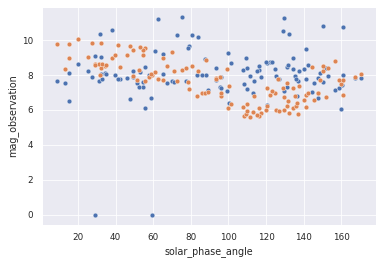

In [26]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

<AxesSubplot:xlabel='solar_phase_angle', ylabel='mag_plus_error'>

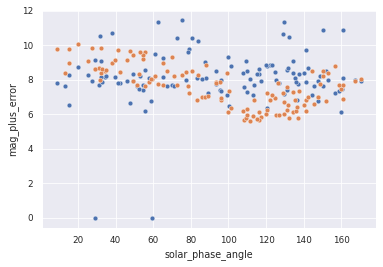

In [25]:
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_plus_error")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", markers='s')

In [35]:
data_plot['solar_phase_angle']

0       37.895225
1      122.190959
2      113.741359
3      130.907579
4       54.835951
          ...    
113     59.079649
114    152.066243
115    147.757302
116     78.521089
117    132.194488
Name: solar_phase_angle, Length: 118, dtype: float64

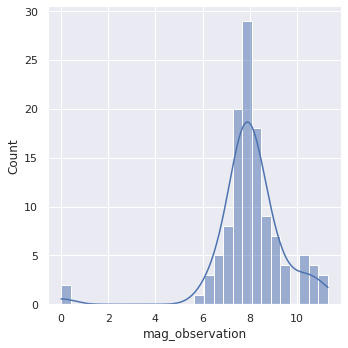

In [26]:
sns.set_theme(style="darkgrid")
sns.displot(data=data_plot, x="mag_observation", kde=True)

In [15]:
result_fit.describe()

,p_value,mixing_coeffient_est,albedo_est,cross_section_est
count,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN


In [14]:
result_fit

,p_value,mixing_coeffient_est,albedo_est,cross_section_est
0,2.398943,0.787,0.716,0.960
1,2.387380,1.034,1.106,0.467


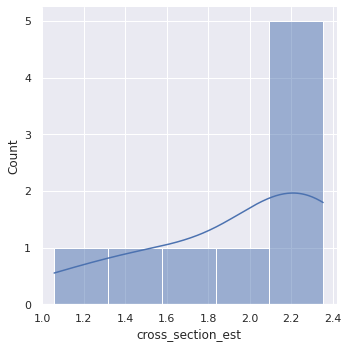

In [21]:
sns.set_theme(style="darkgrid")
sns.displot(data=result_fit, x="cross_section_est", kde=True)

In [ ]:
sns.lineplot(data=result_fit, x="mixing_coeffient_est", y="p_value", markers=True, dashes=False)

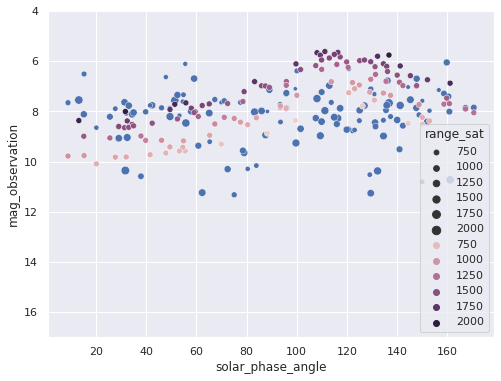

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="mag_observation", size="range_sat")
sns.scatterplot(data=data_plot, x="solar_phase_angle", y="model_value", hue="range_sat", markers='s')
ax.set_ylim(17, 4)
plt.show()

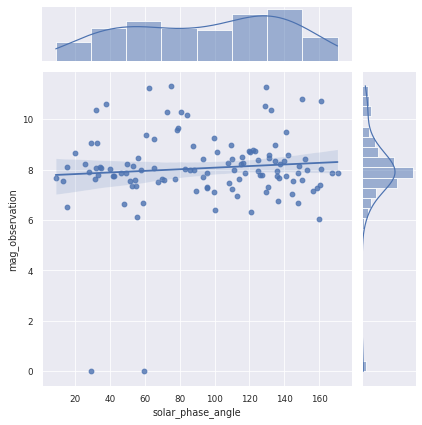

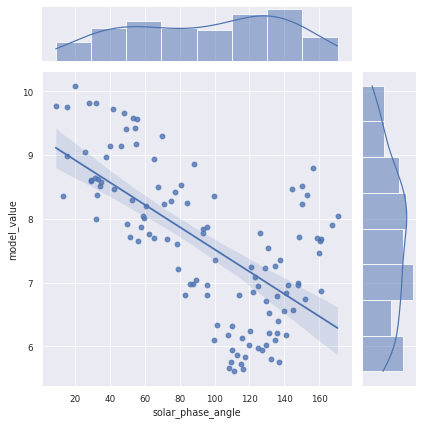

In [20]:
sns.jointplot(data=data_plot, x="solar_phase_angle", y="mag_observation", kind="reg")
sns.jointplot(data=data_plot, x="solar_phase_angle", y="model_value", kind="reg")
sns.set_context("paper")


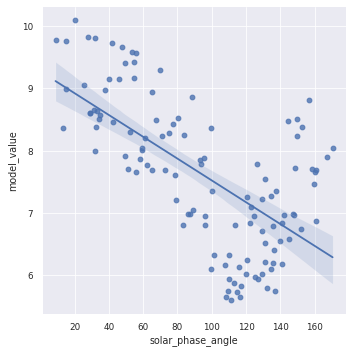

In [22]:
sns.lmplot(x="solar_phase_angle", y="model_value", data=data_plot)